# Projeto: Emissão Acústica Petrobras
## Laboratório de Processamento de Sinais - UFRJ
## Autor: Natanael Junior (natmourajr@lps.ufrj.br)

O objetivo deste notebook é o treinamento e análise de um modelo baseado em kMeans aplicado aos dados do projeto 

In [2]:
# Carregando dados
import os
import scipy.io as sio
import numpy as np
mat_contents = sio.loadmat('../../Data/dadosCP3.mat')

inputMatrix = mat_contents['inputMatrix']
fieldNames = mat_contents['fieldNames']
freqPower = mat_contents['power']
normalizedfreqPower = mat_contents['normalizedPower']

feature_labels = []

for x1, x2 in enumerate(fieldNames):
    for y1, y2 in enumerate(x2):
        feature_labels = np.append(feature_labels,str(y2[0])) 


inputs = inputMatrix.T


target_file = sio.loadmat('../../Data/targetCP3.mat')
target = target_file['targetCP3']
target = np.argmax(target,axis=0)
outputs = target

cat_outputs = -np.ones([outputs.shape[0],len(np.unique(outputs))])
for i,j in enumerate(outputs):
    cat_outputs[i,j] = 1
    
class_labels = ['NP', 'SP', 'UP']
m_colors = ['r', 'g', 'b']

In [56]:
cluster_range

[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]

In [71]:
from sklearn.datasets import make_blobs
from Functions import models

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

# create trn_params obj
trn_params = models.KMeansParams(init='random',precompute_distances=False)

n_folds = 4

folds_selection = "StratifiedKFolds" # "StratifiedKFolds", "KFolds"

folds_filename =  '../Results/%s_%i_folds.jbl'%(folds_selection,n_folds)
#folds_filename =  '../Results/KFolds_%i_folds.jbl'%(n_folds)

if not os.path.isfile(folds_filename):
    if folds_selection == "StratifiedKFolds":
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
        skf.get_n_splits(inputs, outputs)
        joblib.dump(skf, folds_filename)
    elif folds_selection == "KFolds":
        skf = KFold(n_splits=n_folds, shuffle=True)
        skf.get_n_splits(inputs, outputs)
        joblib.dump(skf, folds_filename)
else:
    skf = joblib.load(folds_filename)

kmeans_models = {}
n_clusters = 3
cluster_range = range(120,151,3)
random_state = 170


for ifold, [train_index, test_index] in enumerate(skf.split(inputs, outputs)):

    #normalize data
    scaler = preprocessing.StandardScaler().fit(inputs[train_index,:])
    normalized_inputs = scaler.transform(inputs)
    kmeans_models[ifold] = {}
    
    for i_clusters in cluster_range:
    
        kmeans_models[ifold][i_clusters] = KMeans(n_clusters=i_clusters)
        kmeans_models[ifold][i_clusters].fit(normalized_inputs[train_index,:])
        
        file_name = '../Results/KMeans/model_%i_fold_%i_cluster.jbl'%(ifold,i_clusters)
        if os.path.isfile(file_name):
            continue
    
        joblib.dump(kmeans_models[ifold][i_clusters],file_name, compress=9)
    

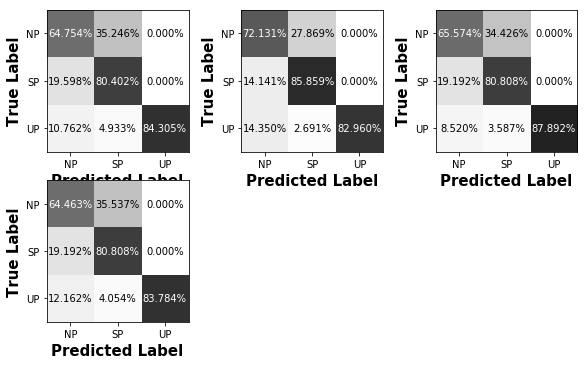

In [72]:
from sklearn.datasets import make_blobs
from Functions import models

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

# create trn_params obj
trn_params = models.KMeansParams(init='random',precompute_distances=False)

n_folds = 4

folds_selection = "StratifiedKFolds" # "StratifiedKFolds", "KFolds"

folds_filename =  '../Results/%s_%i_folds.jbl'%(folds_selection,n_folds)
#folds_filename =  '../Results/KFolds_%i_folds.jbl'%(n_folds)

if not os.path.isfile(folds_filename):
    if folds_selection == "StratifiedKFolds":
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
        skf.get_n_splits(inputs, outputs)
        joblib.dump(skf, folds_filename)
    elif folds_selection == "KFolds":
        skf = KFold(n_splits=n_folds, shuffle=True)
        skf.get_n_splits(inputs, outputs)
        joblib.dump(skf, folds_filename)
else:
    skf = joblib.load(folds_filename)

kmeans_models = {}
n_clusters = 150
random_state = 170

cm = {}

fig = plt.figure(figsize=(10,12))
nrows = 4
ncols = 3
    

for ifold, [train_index, test_index] in enumerate(skf.split(inputs, outputs)):

    #normalize data
    scaler = preprocessing.StandardScaler().fit(inputs[train_index,:])
    normalized_inputs = scaler.transform(inputs)
    kmeans_models[ifold] = {}
    
    cm[ifold] = {}
    file_name = '../Results/KMeans/model_%i_fold_%i_cluster.jbl'%(ifold,i_clusters)
    if not os.path.isfile(file_name):
        continue
    
    
    aux_model = joblib.load(
        '../Results/KMeans/model_%i_fold_%i_cluster.jbl'%(ifold,n_clusters))
        
    classes_per_clusters = np.zeros([len(np.unique(outputs)), n_clusters])
    for i, iclass in enumerate(np.unique(outputs)):
        for j in range(i_clusters):
            classes_per_clusters[i,j] = ((sum(aux_model.predict(normalized_inputs[outputs==iclass])==j).astype('float'))/
                                         sum(aux_model.predict(normalized_inputs[outputs==iclass])).astype('float'))
        
    cluster_classes = np.argmax(classes_per_clusters,axis=0)
    model_output = cluster_classes[aux_model.predict(normalized_inputs)]
        
    cm[ifold] = confusion_matrix(target[test_index], model_output[test_index])
    cm[ifold] = (cm[ifold].astype('float')/ 
                 cm[ifold].sum(axis=1)[:, np.newaxis])
    cm[ifold] = 100.*cm[ifold]
    
    
        
    ax = plt.subplot(nrows,ncols,ifold+1)
    im = ax.imshow(cm[ifold], 
                   interpolation='nearest', 
                   cmap=plt.cm.Greys,clim=(0.0, 100.0))
        
    width, height = cm[ifold].shape
    for x in xrange(width):
        for y in xrange(height):
            if cm[ifold][x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm[ifold][x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm[ifold][x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')
    tick_marks = np.arange(len(class_labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(class_labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(class_labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
        
    fig.subplots_adjust(wspace=0.15, hspace=0.2)



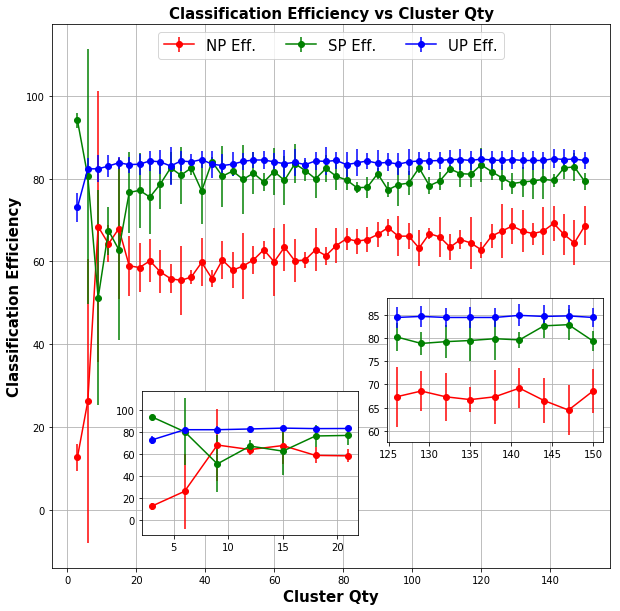

In [171]:
from sklearn.datasets import make_blobs
from Functions import models

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

# create trn_params obj
trn_params = models.KMeansParams(init='random',precompute_distances=False)

n_folds = 4

folds_selection = "StratifiedKFolds" # "StratifiedKFolds", "KFolds"

folds_filename =  '../Results/%s_%i_folds.jbl'%(folds_selection,n_folds)
#folds_filename =  '../Results/KFolds_%i_folds.jbl'%(n_folds)

if not os.path.isfile(folds_filename):
    if folds_selection == "StratifiedKFolds":
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
        skf.get_n_splits(inputs, outputs)
        joblib.dump(skf, folds_filename)
    elif folds_selection == "KFolds":
        skf = KFold(n_splits=n_folds, shuffle=True)
        skf.get_n_splits(inputs, outputs)
        joblib.dump(skf, folds_filename)
else:
    skf = joblib.load(folds_filename)

kmeans_models = {}
cluster_range = range(3,151,3)
random_state = 170

cm = {}

fig = plt.figure(figsize=(10,10))
nrows = 1
ncols = 1
    
eff_classes = np.zeros([n_folds, len(np.unique(outputs)), len(cluster_range)])


out_file_name = '../Results/KMeans/results_n_cluster_analysis.jbl'

if not os.path.isfile(out_file_name):
    
    for ifold, [train_index, test_index] in enumerate(skf.split(inputs, outputs)):

        #normalize data
        scaler = preprocessing.StandardScaler().fit(inputs[train_index,:])
        normalized_inputs = scaler.transform(inputs)
        kmeans_models[ifold] = {}

        file_name = '../Results/KMeans/model_%i_fold_%i_cluster.jbl'%(ifold,i_clusters)
        if not os.path.isfile(file_name):
            continue

        for j_cluster, i_cluster in enumerate(cluster_range):
            file_name = '../Results/KMeans/model_%i_fold_%i_cluster.jbl'%(ifold,i_cluster)
            if not os.path.isfile(file_name):
                continue

            aux_model = joblib.load(file_name)

            classes_per_clusters = np.zeros([len(np.unique(outputs)), n_clusters])
            for i, iclass in enumerate(np.unique(outputs)):
                for j in range(i_clusters):
                    classes_per_clusters[i,j] = ((sum(aux_model.predict(normalized_inputs[outputs==iclass])==j).astype('float'))/
                                                 sum(aux_model.predict(normalized_inputs[outputs==iclass])).astype('float'))

            cluster_classes = np.argmax(classes_per_clusters,axis=0)
            model_output = cluster_classes[aux_model.predict(normalized_inputs)]

            cm = confusion_matrix(target[test_index], model_output[test_index])
            cm = (cm.astype('float')/ 
                  cm.sum(axis=1)[:, np.newaxis])
            cm = 100.*cm
            
            for i_class, j_class in enumerate(np.unique(outputs)):
                eff_classes[ifold, j_class, j_cluster] = cm[j_class][j_class]
    joblib.dump(eff_classes,out_file_name, compress=9)

else:
    eff_classes = joblib.load(out_file_name)

ax = plt.subplot(nrows,ncols,1)
for i_class, j_class in enumerate(np.unique(outputs)):
    ax.errorbar(cluster_range, np.mean(eff_classes[:,i_class,:],axis=0),
                np.std(eff_classes[:,i_class,:],axis=0), 
                color=m_colors[i_class],fmt='-o',label='%s Eff.'%class_labels[i_class])

ax1 = plt.axes([.25, .17, .3, .2],)
for i_class, j_class in enumerate(np.unique(outputs)):
    ax1.errorbar(cluster_range[0:7], np.mean(eff_classes[:,i_class,0:7],axis=0),
                np.std(eff_classes[:,i_class,0:7],axis=0), 
                color=m_colors[i_class],fmt='-o',label='%s Eff.'%class_labels[i_class])
ax1.grid()

ax2 = plt.axes([.59, .3, .3, .2],)

for i_class, j_class in enumerate(np.unique(outputs)):
    ax2.errorbar(cluster_range[-9:], np.mean(eff_classes[:,i_class,-9:],axis=0),
                np.std(eff_classes[:,i_class,-9:],axis=0), 
                color=m_colors[i_class],fmt='-o',label='%s Eff.'%class_labels[i_class])
ax2.grid()

    
ax.grid()
ax.set_title('Classification Efficiency vs Cluster Qty',fontweight='bold',fontsize=15)
ax.set_ylabel('Classification Efficiency',fontweight='bold',fontsize=15)
ax.set_xlabel('Cluster Qty',fontweight='bold',fontsize=15)
ax.legend(loc='upper center',ncol=3,fontsize=15)

Text(0.5,0,'Predicted Label')

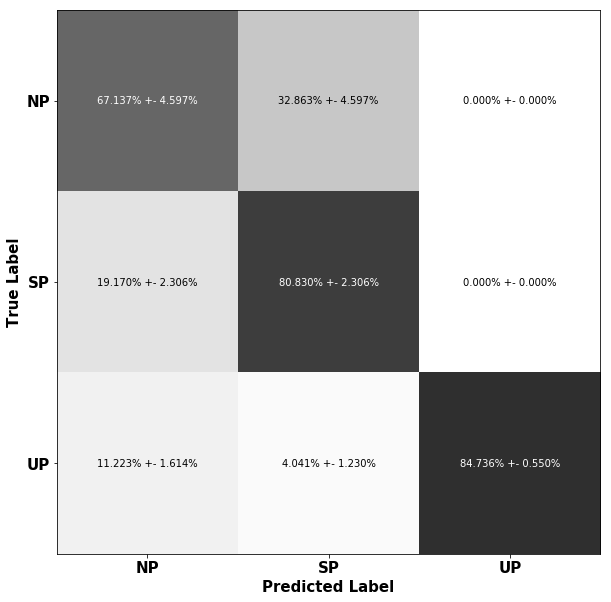

In [176]:
from sklearn.datasets import make_blobs
from Functions import models

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

# create trn_params obj
trn_params = models.KMeansParams(init='random',precompute_distances=False)

n_folds = 4

folds_selection = "StratifiedKFolds" # "StratifiedKFolds", "KFolds"

folds_filename =  '../Results/%s_%i_folds.jbl'%(folds_selection,n_folds)
#folds_filename =  '../Results/KFolds_%i_folds.jbl'%(n_folds)

if not os.path.isfile(folds_filename):
    if folds_selection == "StratifiedKFolds":
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
        skf.get_n_splits(inputs, outputs)
        joblib.dump(skf, folds_filename)
    elif folds_selection == "KFolds":
        skf = KFold(n_splits=n_folds, shuffle=True)
        skf.get_n_splits(inputs, outputs)
        joblib.dump(skf, folds_filename)
else:
    skf = joblib.load(folds_filename)

kmeans_models = {}
n_clusters = 141
random_state = 170

cm = {}

fig = plt.figure(figsize=(12,10))
nrows = 1
ncols = 1
    

for ifold, [train_index, test_index] in enumerate(skf.split(inputs, outputs)):

    #normalize data
    scaler = preprocessing.StandardScaler().fit(inputs[train_index,:])
    normalized_inputs = scaler.transform(inputs)
    kmeans_models[ifold] = {}
    
    cm[ifold] = {}
    file_name = '../Results/KMeans/model_%i_fold_%i_cluster.jbl'%(ifold,n_clusters)
    if not os.path.isfile(file_name):
        continue
    
    
    aux_model = joblib.load(
        '../Results/KMeans/model_%i_fold_%i_cluster.jbl'%(ifold,n_clusters))
        
    classes_per_clusters = np.zeros([len(np.unique(outputs)), n_clusters])
    for i, iclass in enumerate(np.unique(outputs)):
        for j in range(n_clusters):
            classes_per_clusters[i,j] = ((sum(aux_model.predict(normalized_inputs[outputs==iclass])==j).astype('float'))/
                                         sum(aux_model.predict(normalized_inputs[outputs==iclass])).astype('float'))
        
    cluster_classes = np.argmax(classes_per_clusters,axis=0)
    model_output = cluster_classes[aux_model.predict(normalized_inputs)]
        
    cm[ifold] = confusion_matrix(target[test_index], model_output[test_index])
    cm[ifold] = (cm[ifold].astype('float')/ 
                 cm[ifold].sum(axis=1)[:, np.newaxis])
    cm[ifold] = 100.*cm[ifold]
    
ax = plt.subplot(nrows,ncols,1)

cm_mean = np.mean([cm[key] for key in cm],axis=0)
cm_std = np.std([cm[key] for key in cm],axis=0)

im = ax.imshow(cm_mean, 
               interpolation='nearest', 
               cmap=plt.cm.Greys,clim=(0.0, 100.0))
width, height = cm_mean.shape

for x in xrange(width):
    for y in xrange(height):
        if cm_mean[x][y] < 50.:
            ax.annotate('%1.3f%% +- %1.3f%%'%(cm_mean[x][y],
                                              cm_std[x][y]), 
                        xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%% +- %1.3f%%'%(cm_mean[x][y],
                                              cm_std[x][y]), 
                        xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center', color='white')
            
tick_marks = np.arange(len(class_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(class_labels,fontweight='bold',fontsize=15)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(class_labels,fontweight='bold',fontsize=15)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)


